In [1]:
import pandas as pd
import numpy as np

import requests 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

<h1 align=center><font size = 6>Capstone Project - Clustering of London's Crime Areas </font></h1>


# Capstone Project - Clustering of London's Crime Areas

This notebook will be used for the IBM Applied Data Science Specialisation Capstone Project

## Introduction

The purpose of this project is to segment the different neighbourhoods of London by the different types of crime which occur. This would be of use to:
1) Residents of London - So they can protect themselves of such crimes.

2) Tourists - As above and for an awareness of what crimes to expect in different areas.

3) Businesses - As above and so they can take out appropriate insurance.

4) Insurance companies - Can set insurance premiums taking into consideration the prevalance of crime in a certain neighbourhood.

London will also be segmented by Venues (from the Foursquare API) to see if there is a link to crime.

## The Data

The Crime data will be obtained using the UK Police's API/Crime Data, filtering the data from crimes in 2019 (to exlcude imapcts of Covid-19) by the Metropolitan Police Service which is London's police force. 

Documentation on the API can be found on:https://data.police.uk/docs/ and https://police-api-client-python.readthedocs.io/en/latest/ and Crime Data from https://data.police.uk/data/

Crimes for which location data exists are presented by neighbourhood and latitude and longitude of the crime location. The latitide and longitude data of the neighbourhood of the crime will be used to cluster London's neighbourhood.

### The Crime Data 

Latitude & longitude coordinates for centroids for neighborhoods will be created from the crime data.

In [2]:
crimedata=pd.read_csv('2019-01-metropolitan-street.csv') #Crime Data from https://data.police.uk/data/
crimedata.head(5)

Crime ID    Month  \
0  a8977a2a4e14252420371eb993d52e4d0b8288a7c833e6...  2019-01   
1                                                NaN  2019-01   
2  934e173f2bc2e1dd3a257b37939d8f97575d3eeb89ff0c...  2019-01   
3  4f5b7e424bc78b1fb8c32e07da61176d2cbc5a3849d8e1...  2019-01   
4  53d960600a4a9f54b785f598af4c75bdef2f79bce1a41b...  2019-01   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service  -0.709911   
1  Metropolitan Police Service  Metropolitan Police Service   0.140192   
2  Metropolitan Police Service  Metropolitan Police Service   0.140192   
3  Metropolitan Police Service  Metropolitan Police Service   0.140634   
4  Metropolitan Police Service  Metropolitan Police Service   0.141143   

    Latitude                     Location  LSOA code  \
0  50.784615     On or near Rochester Way  E01031384   
1  51.582311       On or near Hatch Grove  E01000027   
2  51.582311       On or near Hatch Grove  E01000027   
3  51.583427        On or near Rams Grove  E01000027   
4  51.590873  On or near Furze Farm Close  E01000027   

                   LSOA name                    Crime type  \
0                  Arun 018E  Violence and sexual offences   
1  Barking and Dagenham 001A         Anti-social behaviour   
2  Barking and Dagenham 001A                      Burglary   
3  Barking and Dagenham 001A                      Burglary   
4  Barking and Dagenham 001A                         Drugs   

                           Last outcome category  Context  
0                      Status update unavailable      NaN  
1                                            NaN      NaN  
2                      Status update unavailable      NaN  
3                      Status update unavailable      NaN  
4  Investigation complete; no suspect identified      NaN

#### Note "LSOA name" is the neighbourhood name and "Crime type" is the other imporant heading in the data above.

The crime data comes as monthly csv files which will be combined for the year of 2019.

In [3]:
#append the other months crime data for 2019 into one file
for i in range(2,13):
    y='-metropolitan-street.csv'
    if i<10:
        x='2019-0'
    else:
        x='2019-'
    s=x+str(i)+y
    temp=pd.read_csv(s)
    crimedata=crimedata.append(temp,ignore_index=True)
    print(s)
    print(crimedata.shape)

2019-02-metropolitan-street.csv
(175291, 12)
2019-03-metropolitan-street.csv
(272099, 12)
2019-04-metropolitan-street.csv
(363957, 12)
2019-05-metropolitan-street.csv
(460100, 12)
2019-06-metropolitan-street.csv
(556042, 12)
2019-07-metropolitan-street.csv
(655371, 12)
2019-08-metropolitan-street.csv
(746905, 12)
2019-09-metropolitan-street.csv
(834247, 12)
2019-10-metropolitan-street.csv
(930763, 12)
2019-11-metropolitan-street.csv
(1021967, 12)
2019-12-metropolitan-street.csv
(1108042, 12)


In [4]:
crimedata.shape

(1108042, 12)

Looks like their were 1,108,042 reported crime incidents to the Metrpolitan Police in 2019.

In [5]:
crimedata.describe(include='all')

Crime ID    Month  \
count                                              868191  1108042   
unique                                             824564       12   
top     e22dfff770cd32f54941621e0b4a1000168dfa2fbfbd6a...  2019-07   
freq                                                   29    99329   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

                        Reported by                 Falls within  \
count                       1108042                      1108042   
unique                            1                            1   
top     Metropolitan Police Service  Metropolitan Police Service   
freq                        1108042                      1108042   
mean                            NaN                          NaN   
std                             NaN                          NaN   
min                             NaN                          NaN   
25%                             NaN                          NaN   
50%                             NaN                          NaN   
75%                             NaN                          NaN   
max                             NaN                          NaN   

           Longitude      Latitude                Location  LSOA code  \
count   1.094874e+06  1.094874e+06                 1108042    1094874   
unique           NaN           NaN                   35350       6231   
top              NaN           NaN  On or near Supermarket  E01004734   
freq             NaN           NaN                   41215      10046   
mean   -1.214002e-01  5.151171e+01                     NaN        NaN   
std     1.505561e-01  7.413635e-02                     NaN        NaN   
min    -5.086899e+00  5.016026e+01                     NaN        NaN   
25%    -2.002250e-01  5.147218e+01                     NaN        NaN   
50%    -1.170400e-01  5.151506e+01                     NaN        NaN   
75%    -3.502100e-02  5.155337e+01                     NaN        NaN   
max     1.756430e+00  5.569178e+01                     NaN        NaN   

               LSOA name             Crime type      Last outcome category  \
count            1094874                1108042                     868191   
unique              6231                     14                         23   
top     Westminster 018A  Anti-social behaviour  Status update unavailable   
freq               10046                 239851                     575309   
mean                 NaN                    NaN                        NaN   
std                  NaN                    NaN                        NaN   
min                  NaN                    NaN                        NaN   
25%                  NaN                    NaN                        NaN   
50%                  NaN                    NaN                        NaN   
75%                  NaN                    NaN                        NaN   
max                  NaN                    NaN                        NaN   

        Context  
count       0.0  
unique      NaN  
top         NaN  
freq        NaN  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [6]:
crimedata=crimedata[crimedata.Location!='No Location'] #removing rows where there is no location data as we want to see crime location
crimedata.rename({"LSOA name":"Neighbourhood"},axis=1,inplace=True)
crimedata.describe(include='all')

Crime ID    Month  \
count                                              855061  1094874   
unique                                             811989       12   
top     e22dfff770cd32f54941621e0b4a1000168dfa2fbfbd6a...  2019-07   
freq                                                   29    98310   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

                        Reported by                 Falls within  \
count                       1094874                      1094874   
unique                            1                            1   
top     Metropolitan Police Service  Metropolitan Police Service   
freq                        1094874                      1094874   
mean                            NaN                          NaN   
std                             NaN                          NaN   
min                             NaN                          NaN   
25%                             NaN                          NaN   
50%                             NaN                          NaN   
75%                             NaN                          NaN   
max                             NaN                          NaN   

           Longitude      Latitude                Location  LSOA code  \
count   1.094874e+06  1.094874e+06                 1094874    1094874   
unique           NaN           NaN                   35349       6231   
top              NaN           NaN  On or near Supermarket  E01004734   
freq             NaN           NaN                   41215      10046   
mean   -1.214002e-01  5.151171e+01                     NaN        NaN   
std     1.505561e-01  7.413635e-02                     NaN        NaN   
min    -5.086899e+00  5.016026e+01                     NaN        NaN   
25%    -2.002250e-01  5.147218e+01                     NaN        NaN   
50%    -1.170400e-01  5.151506e+01                     NaN        NaN   
75%    -3.502100e-02  5.155337e+01                     NaN        NaN   
max     1.756430e+00  5.569178e+01                     NaN        NaN   

           Neighbourhood             Crime type      Last outcome category  \
count            1094874                1094874                     855061   
unique              6231                     14                         23   
top     Westminster 018A  Anti-social behaviour  Status update unavailable   
freq               10046                 239813                     565694   
mean                 NaN                    NaN                        NaN   
std                  NaN                    NaN                        NaN   
min                  NaN                    NaN                        NaN   
25%                  NaN                    NaN                        NaN   
50%                  NaN                    NaN                        NaN   
75%                  NaN                    NaN                        NaN   
max                  NaN                    NaN                        NaN   

        Context  
count       0.0  
unique      NaN  
top         NaN  
freq        NaN  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN

In [7]:
crimedata.reset_index(drop=True, inplace=True)
crimedata

Crime ID    Month  \
0        a8977a2a4e14252420371eb993d52e4d0b8288a7c833e6...  2019-01   
1                                                      NaN  2019-01   
2        934e173f2bc2e1dd3a257b37939d8f97575d3eeb89ff0c...  2019-01   
3        4f5b7e424bc78b1fb8c32e07da61176d2cbc5a3849d8e1...  2019-01   
4        53d960600a4a9f54b785f598af4c75bdef2f79bce1a41b...  2019-01   
...                                                    ...      ...   
1094869  dd915e6ad5a78535dfc465680953f7d9e7fe5e4dfca024...  2019-12   
1094870  2ac8086a757170d707b83b243b9cf1afa5dad955825443...  2019-12   
1094871  ec2c1541e034d4999c6c8c795f12d4b587054cd2e46f3c...  2019-12   
1094872  04ecebb59028f65679de4391d07692340e5e027ffbfb61...  2019-12   
1094873  d06be25766b26c9eaba9c91f119e7cb9e3d1f7c7ff8a96...  2019-12   

                         Reported by                 Falls within  Longitude  \
0        Metropolitan Police Service  Metropolitan Police Service  -0.709911   
1        Metropolitan Police Service  Metropolitan Police Service   0.140192   
2        Metropolitan Police Service  Metropolitan Police Service   0.140192   
3        Metropolitan Police Service  Metropolitan Police Service   0.140634   
4        Metropolitan Police Service  Metropolitan Police Service   0.141143   
...                              ...                          ...        ...   
1094869  Metropolitan Police Service  Metropolitan Police Service  -0.534400   
1094870  Metropolitan Police Service  Metropolitan Police Service  -2.121588   
1094871  Metropolitan Police Service  Metropolitan Police Service  -0.384598   
1094872  Metropolitan Police Service  Metropolitan Police Service  -0.777389   
1094873  Metropolitan Police Service  Metropolitan Police Service  -0.711593   

          Latitude                     Location  LSOA code  \
0        50.784615     On or near Rochester Way  E01031384   
1        51.582311       On or near Hatch Grove  E01000027   
2        51.582311       On or near Hatch Grove  E01000027   
3        51.583427        On or near Rams Grove  E01000027   
4        51.590873  On or near Furze Farm Close  E01000027   
...            ...                          ...        ...   
1094869  51.330219       On or near River Court  E01030984   
1094870  52.579894     On or near Vicarage Road  E01010530   
1094871  50.809639      On or near Bowers Court  E01031809   
1094872  51.625615      On or near Pettifer Way  E01017907   
1094873  51.616630   On or near Old Coach Drive  E01017908   

                     Neighbourhood                    Crime type  \
0                        Arun 018E  Violence and sexual offences   
1        Barking and Dagenham 001A         Anti-social behaviour   
2        Barking and Dagenham 001A                      Burglary   
3        Barking and Dagenham 001A                      Burglary   
4        Barking and Dagenham 001A                         Drugs   
...                            ...                           ...   
1094869                Woking 004E  Violence and sexual offences   
1094870         Wolverhampton 035H                      Burglary   
1094871              Worthing 010C                   Other theft   
1094872               Wycombe 013E                         Drugs   
1094873               Wycombe 016A  Violence and sexual offences   

                                 Last outcome category  Context  
0                            Status update unavailable      NaN  
1                                                  NaN      NaN  
2                            Status update unavailable      NaN  
3                            Status update unavailable      NaN  
4        Investigation complete; no suspect identified      NaN  
...                                                ...      ...  
1094869                      Status update unavailable      NaN  
1094870                      Status update unavailable      NaN  
1094871                      Status update unavailable      NaN  
1094872       

In [8]:
crimedata['Neighbourhood'] = crimedata['Neighbourhood'].map(lambda x: str(x)[:-5])

In [9]:
crimedata.tail(5)

Crime ID    Month  \
1094869  dd915e6ad5a78535dfc465680953f7d9e7fe5e4dfca024...  2019-12   
1094870  2ac8086a757170d707b83b243b9cf1afa5dad955825443...  2019-12   
1094871  ec2c1541e034d4999c6c8c795f12d4b587054cd2e46f3c...  2019-12   
1094872  04ecebb59028f65679de4391d07692340e5e027ffbfb61...  2019-12   
1094873  d06be25766b26c9eaba9c91f119e7cb9e3d1f7c7ff8a96...  2019-12   

                         Reported by                 Falls within  Longitude  \
1094869  Metropolitan Police Service  Metropolitan Police Service  -0.534400   
1094870  Metropolitan Police Service  Metropolitan Police Service  -2.121588   
1094871  Metropolitan Police Service  Metropolitan Police Service  -0.384598   
1094872  Metropolitan Police Service  Metropolitan Police Service  -0.777389   
1094873  Metropolitan Police Service  Metropolitan Police Service  -0.711593   

          Latitude                    Location  LSOA code  Neighbourhood  \
1094869  51.330219      On or near River Court  E01030984         Woking   
1094870  52.579894    On or near Vicarage Road  E01010530  Wolverhampton   
1094871  50.809639     On or near Bowers Court  E01031809       Worthing   
1094872  51.625615     On or near Pettifer Way  E01017907        Wycombe   
1094873  51.616630  On or near Old Coach Drive  E01017908        Wycombe   

                           Crime type      Last outcome category  Context  
1094869  Violence and sexual offences  Status update unavailable      NaN  
1094870                      Burglary  Status update unavailable      NaN  
1094871                   Other theft  Status update unavailable      NaN  
1094872                         Drugs  Status update unavailable      NaN  
1094873  Violence and sexual offences  Status update unavailable      NaN

#### Getting the mean crime location for each neighbourhood

In [10]:
neigh=crimedata[['Neighbourhood','Longitude','Latitude']].groupby('Neighbourhood').mean() 
neigh.rename({"Longitude":"Long_Neigh","Latitude":"Lat_Neigh"},axis=1,inplace=True)
neigh

Long_Neigh  Lat_Neigh
Neighbourhood                       
Adur            -0.335092  50.837110
Amber Valley    -1.493708  52.982886
Arun            -0.658131  50.790812
Ashfield        -1.274270  53.121023
Ashford          0.814516  51.125907
...                   ...        ...
Wychavon        -1.948278  52.097865
Wycombe         -0.743618  51.612349
Wyre            -2.972229  53.876885
Wyre Forest     -2.178788  52.405668
York            -1.087424  53.963431

[290 rows x 2 columns]

In [11]:
neigh.index

Index(['Adur', 'Amber Valley', 'Arun', 'Ashfield', 'Ashford', 'Aylesbury Vale',
       'Babergh', 'Barking and Dagenham', 'Barnet', 'Basildon',
       ...
       'Wokingham', 'Wolverhampton', 'Worcester', 'Worthing', 'Wrexham',
       'Wychavon', 'Wycombe', 'Wyre', 'Wyre Forest', 'York'],
      dtype='object', name='Neighbourhood', length=290)

In [12]:
crimedata=crimedata.join(neigh,how="inner",on=["Neighbourhood"])
crimedata.describe(include="all")

Crime ID    Month  \
count                                              855061  1094874   
unique                                             811989       12   
top     e22dfff770cd32f54941621e0b4a1000168dfa2fbfbd6a...  2019-07   
freq                                                   29    98310   
mean                                                  NaN      NaN   
std                                                   NaN      NaN   
min                                                   NaN      NaN   
25%                                                   NaN      NaN   
50%                                                   NaN      NaN   
75%                                                   NaN      NaN   
max                                                   NaN      NaN   

                        Reported by                 Falls within  \
count                       1094874                      1094874   
unique                            1                            1   
top     Metropolitan Police Service  Metropolitan Police Service   
freq                        1094874                      1094874   
mean                            NaN                          NaN   
std                             NaN                          NaN   
min                             NaN                          NaN   
25%                             NaN                          NaN   
50%                             NaN                          NaN   
75%                             NaN                          NaN   
max                             NaN                          NaN   

           Longitude      Latitude                Location  LSOA code  \
count   1.094874e+06  1.094874e+06                 1094874    1094874   
unique           NaN           NaN                   35349       6231   
top              NaN           NaN  On or near Supermarket  E01004734   
freq             NaN           NaN                   41215      10046   
mean   -1.214002e-01  5.151171e+01                     NaN        NaN   
std     1.505561e-01  7.413635e-02                     NaN        NaN   
min    -5.086899e+00  5.016026e+01                     NaN        NaN   
25%    -2.002250e-01  5.147218e+01                     NaN        NaN   
50%    -1.170400e-01  5.151506e+01                     NaN        NaN   
75%    -3.502100e-02  5.155337e+01                     NaN        NaN   
max     1.756430e+00  5.569178e+01                     NaN        NaN   

       Neighbourhood             Crime type      Last outcome category  \
count        1094874                1094874                     855061   
unique           290                     14                         23   
top      Westminster  Anti-social behaviour  Status update unavailable   
freq           90956                 239813                     565694   
mean             NaN                    NaN                        NaN   
std              NaN                    NaN                        NaN   
min              NaN                    NaN                        NaN   
25%              NaN                    NaN                        NaN   
50%              NaN                    NaN                        NaN   
75%              NaN                    NaN                        NaN   
max              NaN                    NaN                        NaN   

        Context    Long_Neigh     Lat_Neigh  
count       0.0  1.094874e+06  1.094874e+06  
unique      NaN           NaN           NaN  
top         NaN           NaN           NaN  
freq        NaN           NaN           NaN  
mean        NaN -1.214002e-01  5.151171e+01  
std         NaN  1.478189e-01  7.196570e-02  
min         NaN -5.086899e+00  5.016026e+01  
25%         NaN -1.900963e-01  5.147079e+01  
50%         NaN -1.092296e-01  5.151846e+01  
75%         NaN -4.306479e-02  5.154750e+01  
max         NaN  1.715932e+00  5.543564e+01

#### Mapping the crime data neighbourhoods

In [13]:
address = 'London,UK'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [14]:
# creating map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, Neighbourhood in zip(neigh['Lat_Neigh'], neigh['Long_Neigh'], neigh.index):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

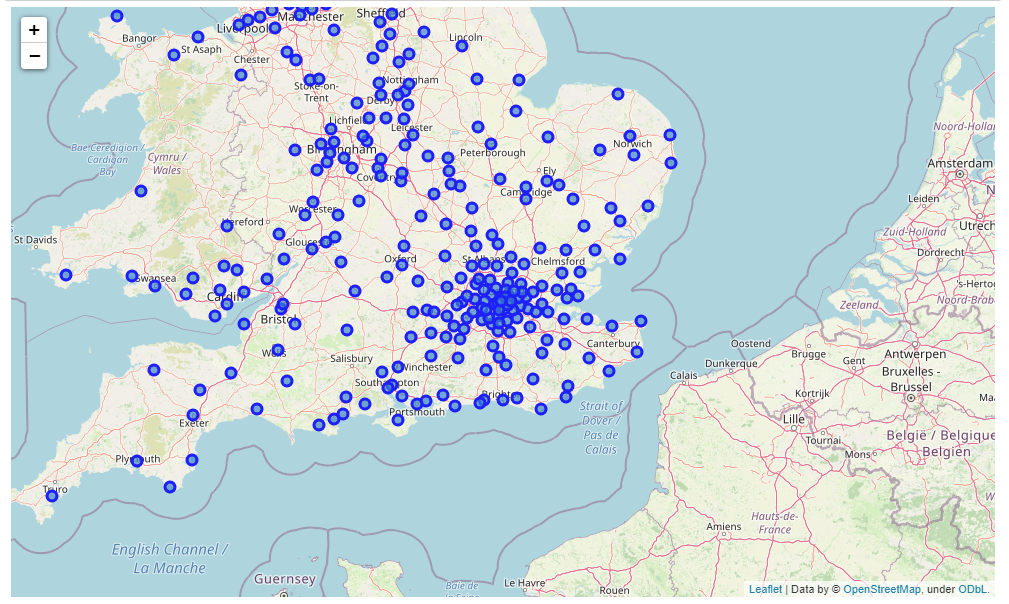

#### Looks like the data needs to be cleaned as it contains non-London data (which may have been reported to the Met Police due to a London relation) but we only want crime that took place in London.

In [15]:
#using long lat boundaries of London from google maps
print("Shape at start= ",neigh.shape)
neigh=neigh[neigh.Lat_Neigh<51.686059]
neigh=neigh[neigh.Lat_Neigh>51.258456]

Shape at start=  (290, 2)


In [16]:
neigh=neigh[neigh.Long_Neigh>-0.504727]
neigh=neigh[neigh.Long_Neigh<0.284902]
print("Shape at end= ",neigh.shape)

Shape at end=  (44, 2)


In [17]:
# creating map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Neighbourhood in zip(neigh['Lat_Neigh'],neigh['Long_Neigh'], neigh.index):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

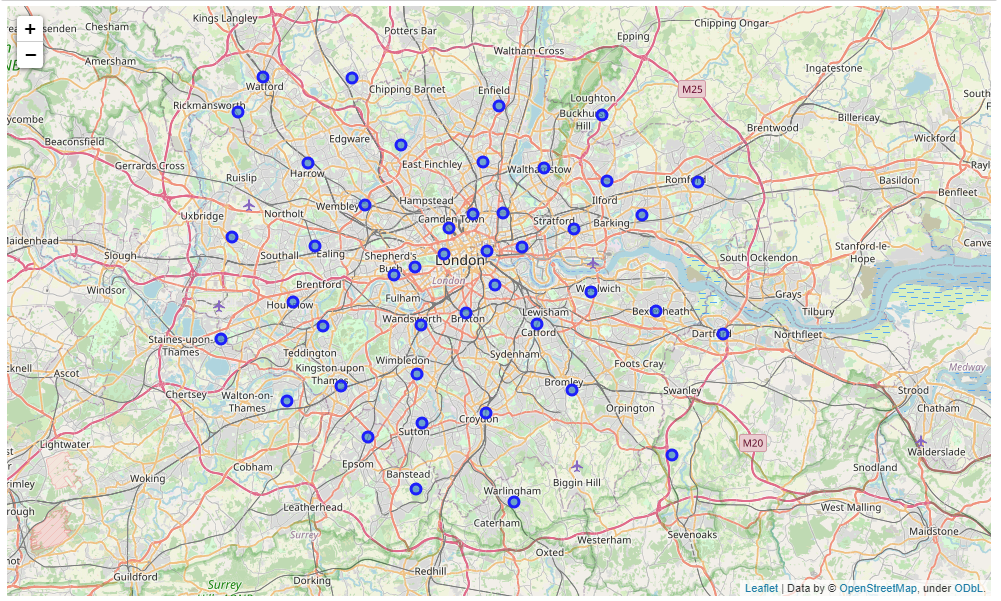

#### The above looks much better and now to save the cleaned data set

In [18]:
print("Shape at start= ",crimedata.shape)
crimedata=crimedata[crimedata.Lat_Neigh<51.686059]
crimedata=crimedata[crimedata.Lat_Neigh>51.258456]
crimedata=crimedata[crimedata.Long_Neigh>-0.504727]
crimedata=crimedata[crimedata.Long_Neigh<0.284902]
print("Shape at end= ",crimedata.shape)

Shape at start=  (1094874, 14)
Shape at end=  (1093359, 14)


In [19]:
crimedata

Crime ID    Month  \
1                                                      NaN  2019-01   
2        934e173f2bc2e1dd3a257b37939d8f97575d3eeb89ff0c...  2019-01   
3        4f5b7e424bc78b1fb8c32e07da61176d2cbc5a3849d8e1...  2019-01   
4        53d960600a4a9f54b785f598af4c75bdef2f79bce1a41b...  2019-01   
5        023cbb7544aa59fc23c4e53d385bdc2d1c854591b42583...  2019-01   
...                                                    ...      ...   
1074075  917b099cde42fd70fa697b75d555c940df41a21f032b05...  2019-12   
1074076  5a0af81f5e97218dc6df9397897618ed2fe385829ce488...  2019-12   
1074077  5a0af81f5e97218dc6df9397897618ed2fe385829ce488...  2019-12   
1074078  5a0af81f5e97218dc6df9397897618ed2fe385829ce488...  2019-12   
1074079  e30ac9b7f3bab45b6e3d3dd7f0b7e15fa8e1dadd6631be...  2019-12   

                         Reported by                 Falls within  Longitude  \
1        Metropolitan Police Service  Metropolitan Police Service   0.140192   
2        Metropolitan Police Service  Metropolitan Police Service   0.140192   
3        Metropolitan Police Service  Metropolitan Police Service   0.140634   
4        Metropolitan Police Service  Metropolitan Police Service   0.141143   
5        Metropolitan Police Service  Metropolitan Police Service   0.137065   
...                              ...                          ...        ...   
1074075  Metropolitan Police Service  Metropolitan Police Service   0.163654   
1074076  Metropolitan Police Service  Metropolitan Police Service   0.226874   
1074077  Metropolitan Police Service  Metropolitan Police Service   0.226874   
1074078  Metropolitan Police Service  Metropolitan Police Service   0.226874   
1074079  Metropolitan Police Service  Metropolitan Police Service   0.218864   

          Latitude                     Location  LSOA code  \
1        51.582311       On or near Hatch Grove  E01000027   
2        51.582311       On or near Hatch Grove  E01000027   
3        51.583427        On or near Rams Grove  E01000027   
4        51.590873  On or near Furze Farm Close  E01000027   
5        51.583672    On or near Police Station  E01000027   
...            ...                          ...        ...   
1074075  51.398380     On or near Lavender Hill  E01024478   
1074076  51.302552         On or near Park Lane  E01024450   
1074077  51.302552         On or near Park Lane  E01024450   
1074078  51.302552         On or near Park Lane  E01024450   
1074079  51.288782       On or near High Street  E01024458   

                Neighbourhood                    Crime type  \
1        Barking and Dagenham         Anti-social behaviour   
2        Barking and Dagenham                      Burglary   
3        Barking and Dagenham                      Burglary   
4        Barking and Dagenham                         Drugs   
5        Barking and Dagenham                   Other theft   
...                       ...                           ...   
1074075             Sevenoaks                   Other theft   
1074076             Sevenoaks  Violence and sexual offences   
1074077             Sevenoaks  Violence and sexual offences   
1074078             Sevenoaks  Violence and sexual offences   
1074079             Sevenoaks  Violence and sexual offences   

                                 Last outcome category  Context  Long_Neigh  \
1                                                  NaN      NaN    0.121971   
2                            Status update unavailable      NaN    0.121971   
3                            Status update unavailable      NaN    0.121971   
4        Investigation complete; no suspect identified      NaN    0.121971   
5        Investigation complete; no suspect identified      NaN    0.121971   
...                                                ...      ...         ...   
1074075  Investigation complete; no suspect identified      NaN    0.163847   
1074076                      Status update unavailable      NaN    0.163847   
1074077                

Looks like their were 1,093,359 reported crime incidents which took place in London which covers a significant portion of the 1,108,042 reported crime incidents to the Metrpolitan Police in 2019.

In [20]:
crimedata.to_csv('2019LondonCrimeData.csv') #Save Full 2019 London Crime data

In [21]:
neigh.to_csv('NeighbourhoodData.csv')

## Methodology

For this project we will look to segment the different neighbourhoods of London by the most prevalent crime in that area.

In the first step we collected the crime data from the Metropolitan plice and cleaned this data for crime that only occured in London.

In the second step, we will cluster the neighbourhoods by the most prevalent crimes in the area.

In the third step, we will obtain venue data from the Foursquare API for venues near each neighbourhood centroid.

In the fourth step, we will cluster the neighbours hoods by the most prevalent venues.

In the fith and final step, we will compare the crime and venue clustered neihgbourhoods and see if there is any similarity. 

## Analysis - Crime

We will now segment and cluster London neighbourhoods by the most prevalent crimes in the area.

In [22]:
print('There are {} unique crime categories.'.format(len(crimedata['Crime type'].unique())))

There are 14 unique crime categories.


In [23]:
#hot encoding
london_twohot = pd.get_dummies(crimedata[['Crime type']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
london_twohot['Neighbourhood'] = crimedata['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [london_twohot.columns[-1]] + list(london_twohot.columns[:-1])
london_twohot = london_twohot[fixed_columns]

#group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category
london_grouped2 = london_twohot.groupby('Neighbourhood').mean().reset_index()

In [24]:
# set number of clusters
kclusters = 5

london_grouped2_clustering = london_grouped2.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped2_clustering)


In [25]:
#function to return the most common crimes
def return_most_common_crimes(row, num_top_crimes):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_crimes]

In [26]:
num_top_crimes = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top crimes
columns = ['Neighbourhood']
for ind in np.arange(num_top_crimes):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

# create a new dataframe
Neighbourhoods_crimes_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_crimes_sorted['Neighbourhood'] = london_grouped2['Neighbourhood']

for ind in np.arange(london_grouped2.shape[0]):
    Neighbourhoods_crimes_sorted.iloc[ind, 1:] = return_most_common_crimes(london_grouped2.iloc[ind, :], num_top_crimes)

Neighbourhoods_crimes_sorted.head()

Neighbourhood         1st Most Common Crime  \
0  Barking and Dagenham  Violence and sexual offences   
1                Barnet         Anti-social behaviour   
2                Bexley  Violence and sexual offences   
3                 Brent         Anti-social behaviour   
4               Bromley  Violence and sexual offences   

          2nd Most Common Crime 3rd Most Common Crime 4th Most Common Crime  \
0         Anti-social behaviour         Vehicle crime           Other theft   
1  Violence and sexual offences         Vehicle crime              Burglary   
2         Anti-social behaviour         Vehicle crime              Burglary   
3  Violence and sexual offences         Vehicle crime           Other theft   
4         Anti-social behaviour         Vehicle crime              Burglary   

  5th Most Common Crime  
0              Burglary  
1           Other theft  
2           Other theft  
3              Burglary  
4           Other theft

In [27]:
# add clustering labels
Neighbourhoods_crimes_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [28]:
london_merged2 = neigh

# merge toronto_grouped with toronto_data to add latitude/longitude for each Neighbourhood
london_merged2 = london_merged2.join(Neighbourhoods_crimes_sorted.set_index('Neighbourhood'), on='Neighbourhood')
london_merged2.head() # check the last columns!

Long_Neigh  Lat_Neigh  Cluster Labels  \
Neighbourhood                                                 
Barking and Dagenham    0.121971  51.545408               2   
Barnet                 -0.208844  51.604835               2   
Bexley                  0.141500  51.463565               2   
Brent                  -0.258462  51.554171               2   
Bromley                 0.026565  51.396167               2   

                             1st Most Common Crime  \
Neighbourhood                                        
Barking and Dagenham  Violence and sexual offences   
Barnet                       Anti-social behaviour   
Bexley                Violence and sexual offences   
Brent                        Anti-social behaviour   
Bromley               Violence and sexual offences   

                             2nd Most Common Crime 3rd Most Common Crime  \
Neighbourhood                                                              
Barking and Dagenham         Anti-social behaviour         Vehicle crime   
Barnet                Violence and sexual offences         Vehicle crime   
Bexley                       Anti-social behaviour         Vehicle crime   
Brent                 Violence and sexual offences         Vehicle crime   
Bromley                      Anti-social behaviour         Vehicle crime   

                     4th Most Common Crime 5th Most Common Crime  
Neighbourhood                                                     
Barking and Dagenham           Other theft              Burglary  
Barnet                            Burglary           Other theft  
Bexley                            Burglary           Other theft  
Brent                          Other theft              Burglary  
Bromley                           Burglary           Other theft

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged2['Lat_Neigh'], london_merged2['Long_Neigh'], london_merged2.index, london_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

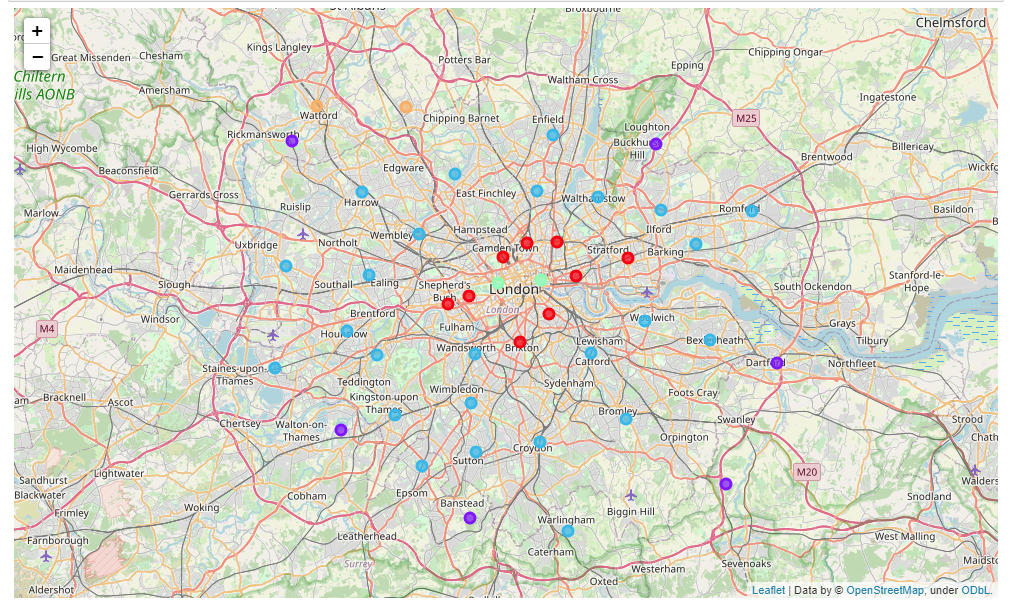

#### Cluster 0 - Red

In [106]:
london_merged2.loc[london_merged2['Cluster Labels'] ==0, london_merged2.columns[[2] + list(range(3, london_merged2.shape[1]))]]

Cluster Labels         1st Most Common Crime  \
Neighbourhood                                                          
Camden                               0         Anti-social behaviour   
Hackney                              0         Anti-social behaviour   
Hammersmith and Fulham               0         Anti-social behaviour   
Islington                            0         Anti-social behaviour   
Kensington and Chelsea               0         Anti-social behaviour   
Lambeth                              0         Anti-social behaviour   
Newham                               0  Violence and sexual offences   
Southwark                            0         Anti-social behaviour   
Tower Hamlets                        0         Anti-social behaviour   

                               2nd Most Common Crime  \
Neighbourhood                                          
Camden                                   Other theft   
Hackney                 Violence and sexual offences   
Hammersmith and Fulham  Violence and sexual offences   
Islington               Violence and sexual offences   
Kensington and Chelsea                   Other theft   
Lambeth                 Violence and sexual offences   
Newham                         Anti-social behaviour   
Southwark               Violence and sexual offences   
Tower Hamlets           Violence and sexual offences   

                               3rd Most Common Crime  4th Most Common Crime  \
Neighbourhood                                                                 
Camden                  Violence and sexual offences  Theft from the person   
Hackney                                  Other theft          Vehicle crime   
Hammersmith and Fulham                   Other theft          Vehicle crime   
Islington                                Other theft  Theft from the person   
Kensington and Chelsea  Violence and sexual offences          Vehicle crime   
Lambeth                                  Other theft          Vehicle crime   
Newham                                 Vehicle crime            Other theft   
Southwark                                Other theft          Vehicle crime   
Tower Hamlets                            Other theft          Vehicle crime   

                        5th Most Common Crime  
Neighbourhood                                  
Camden                          Vehicle crime  
Hackney                              Burglary  
Hammersmith and Fulham               Burglary  
Islington                       Vehicle crime  
Kensington and Chelsea               Burglary  
Lambeth                              Burglary  
Newham                                  Drugs  
Southwark               Theft from the person  
Tower Hamlets                        Burglary

#### Cluster 1 - Purple

In [107]:
london_merged2.loc[london_merged2['Cluster Labels'] ==1, london_merged2.columns[[2] + list(range(3, london_merged2.shape[1]))]]

Cluster Labels         1st Most Common Crime  \
Neighbourhood                                                        
Dartford                           1  Violence and sexual offences   
Elmbridge                          1  Violence and sexual offences   
Epping Forest                      1  Violence and sexual offences   
Reigate and Banstead               1  Violence and sexual offences   
Sevenoaks                          1  Violence and sexual offences   
Three Rivers                       1  Violence and sexual offences   

                     2nd Most Common Crime      3rd Most Common Crime  \
Neighbourhood                                                           
Dartford                     Vehicle crime                Other theft   
Elmbridge                      Other theft  Criminal damage and arson   
Epping Forest                Vehicle crime      Anti-social behaviour   
Reigate and Banstead         Vehicle crime                   Burglary   
Sevenoaks                    Vehicle crime                Other theft   
Three Rivers                 Vehicle crime                Other theft   

                          4th Most Common Crime  5th Most Common Crime  
Neighbourhood                                                           
Dartford              Criminal damage and arson                  Drugs  
Elmbridge                                 Drugs          Vehicle crime  
Epping Forest                       Other theft                  Drugs  
Reigate and Banstead               Public order  Anti-social behaviour  
Sevenoaks                 Anti-social behaviour                  Drugs  
Three Rivers                            Robbery               Burglary

#### Cluster 2 - Blue

In [108]:
london_merged2.loc[london_merged2['Cluster Labels'] ==2, london_merged2.columns[[2] + list(range(3, london_merged2.shape[1]))]]

Cluster Labels         1st Most Common Crime  \
Neighbourhood                                                        
Barking and Dagenham               2  Violence and sexual offences   
Barnet                             2         Anti-social behaviour   
Bexley                             2  Violence and sexual offences   
Brent                              2         Anti-social behaviour   
Bromley                            2  Violence and sexual offences   
Croydon                            2  Violence and sexual offences   
Ealing                             2         Anti-social behaviour   
Enfield                            2         Anti-social behaviour   
Epsom and Ewell                    2  Violence and sexual offences   
Greenwich                          2  Violence and sexual offences   
Haringey                           2         Anti-social behaviour   
Harrow                             2         Anti-social behaviour   
Havering                           2  Violence and sexual offences   
Hillingdon                         2         Anti-social behaviour   
Hounslow                           2  Violence and sexual offences   
Kingston upon Thames               2  Violence and sexual offences   
Lewisham                           2  Violence and sexual offences   
Merton                             2  Violence and sexual offences   
Redbridge                          2  Violence and sexual offences   
Richmond upon Thames               2         Anti-social behaviour   
Spelthorne                         2  Violence and sexual offences   
Sutton                             2  Violence and sexual offences   
Tandridge                          2         Anti-social behaviour   
Waltham Forest                     2         Anti-social behaviour   
Wandsworth                         2  Violence and sexual offences   

                             2nd Most Common Crime  3rd Most Common Crime  \
Neighbourhood                                                               
Barking and Dagenham         Anti-social behaviour          Vehicle crime   
Barnet                Violence and sexual offences          Vehicle crime   
Bexley                       Anti-social behaviour          Vehicle crime   
Brent                 Violence and sexual offences          Vehicle crime   
Bromley                      Anti-social behaviour          Vehicle crime   
Croydon                      Anti-social behaviour          Vehicle crime   
Ealing                Violence and sexual offences          Vehicle crime   
Enfield               Violence and sexual offences          Vehicle crime   
Epsom and Ewell                           Burglary          Vehicle crime   
Greenwich                    Anti-social behaviour          Vehicle crime   
Haringey              Violence and sexual offences          Vehicle crime   
Harrow                Violence and sexual offences          Vehicle crime   
Havering                     Anti-social behaviour          Vehicle crime   
Hillingdon            Violence and sexual offences          Vehicle crime   
Hounslow                     Anti-social behaviour          Vehicle crime   
Kingston upon Thames         Anti-social behaviour          Vehicle crime   
Lewisham                     Anti-social behaviour          Vehicle crime   
Merton                       Anti-social behaviour          Vehicle crime   
Redbridge                    Anti-social behaviour          Vehicle crime   
Richmond upon Thames  Violence and sexual offences          Vehicle crime   
Spelthorne                           Vehicle crime  Anti-social behaviour   
Sutton                       Anti-social behaviour          Vehicle crime   
Tandridge             Violence and sexual offences            Other theft   
Waltham Forest        Violence and sexual offences          Vehicle crime   
Wandsworth                   Anti-social behaviour          Vehicle crime   

                      4th Most Common Crime      5t

#### Cluster 3 - Green

In [109]:
london_merged2.loc[london_merged2['Cluster Labels'] ==3, london_merged2.columns[[2] + list(range(3, london_merged2.shape[1]))]]

Cluster Labels 1st Most Common Crime  2nd Most Common Crime  \
Neighbourhood                                                                 
City of London               3           Other theft  Theft from the person   
Westminster                  3           Other theft  Anti-social behaviour   

                       3rd Most Common Crime         4th Most Common Crime  \
Neighbourhood                                                                
City of London  Violence and sexual offences         Anti-social behaviour   
Westminster            Theft from the person  Violence and sexual offences   

               5th Most Common Crime  
Neighbourhood                         
City of London         Bicycle theft  
Westminster                 Burglary

#### Cluster 4 - Orange

In [110]:
london_merged2.loc[london_merged2['Cluster Labels'] ==4, london_merged2.columns[[2] + list(range(3, london_merged2.shape[1]))]]

Cluster Labels         1st Most Common Crime  \
Neighbourhood                                                 
Hertsmere                   4  Violence and sexual offences   
Watford                     4  Violence and sexual offences   

              2nd Most Common Crime  3rd Most Common Crime  \
Neighbourhood                                                
Hertsmere             Vehicle crime  Anti-social behaviour   
Watford                Public order          Vehicle crime   

              4th Most Common Crime      5th Most Common Crime  
Neighbourhood                                                   
Hertsmere                   Robbery  Criminal damage and arson  
Watford                     Robbery                Other theft

## Results and discussion on Crime Data

It looks like the clusters for crime in London vary radially from the centre of London. Delving deeper into the clusters (see above) it appears that:

Cluster 3 (Green) - Central London: The crimes here are primarily theft related which makes sense as this is the centre of London with many tourist attractions and so there is ample opportunity for theft.

Cluster 0 (Red) - Inner City: These represent an area that surrounds the centre of London and is very populous with many residents and families here living close to the centre of London for work. The majority of crimes here are related to Anti-social behaviour and violence or theft. This makes sense due to these being a very densely populated area where people are less likely to get along.

Cluster 2 (Blue) - Inner Suburbs: This cluster can be described as the inner suburbs which is slightly less densely populated than the Inner city. The majority of crimes being committed here are a combination of violent crimes, anti-social behaviour and vehicle crime. This makes sense as we move away from the centre of London, the police force have more ground to cover which present more opportunity for criminals to be violent and not get caught immediately, also moving away from the centre of London there is more reason for people to have cars and therefore more opportunity to steal cars. However, it is still densely populated enough for anti-social behaviour still to be a dominant crime.

Cluster 1 (Purple) - Outer suburbs: This cluster can be described as the outer suburbs which is much less densely populated than the Inner city. The majority of crimes here are violent crimes and vehicle theft. Which makes sense as per the logic in cluster to as we move further away from the centre of London, the police force have more ground to cover which present more opportunity for criminals to be violent and not get caught immediately, also moving away from the centre of London there is more reason for people to have cars and therefore more opportunity to steal cars.

Cluster 4 (Orange) - Outer towns: These locations can be considered as Towns within Greater London which have their own identities and issues. With crime types likely to be unique to each area. That being said the majority of crime is violent which makes sense as these areas are less densely populated than other areas in London.

### Foursquare Data

Using the crime Neighbourhood date we can use the Foursquare API to get info on venues in each neighborhood.

#### Foursquare Credentials and Version

Credentials will be removed for github upload

In [5]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [63]:
#function to get nearby venues to location
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [64]:
neigh=pd.read_csv('NeighbourhoodData.csv') 

In [65]:
london_venues = getNearbyVenues(names=neigh['Neighbourhood'],
                                   latitudes=neigh['Lat_Neigh'],
                                   longitudes=neigh['Long_Neigh']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
City of London
Croydon
Dartford
Ealing
Elmbridge
Enfield
Epping Forest
Epsom and Ewell
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hertsmere
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Reigate and Banstead
Richmond upon Thames
Sevenoaks
Southwark
Spelthorne
Sutton
Tandridge
Three Rivers
Tower Hamlets
Waltham Forest
Wandsworth
Watford
Westminster


In [66]:
print(london_venues.shape)
london_venues.head()

(3231, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Barking and Dagenham               51.545408                 0.121971   
1  Barking and Dagenham               51.545408                 0.121971   
2  Barking and Dagenham               51.545408                 0.121971   
3  Barking and Dagenham               51.545408                 0.121971   
4  Barking and Dagenham               51.545408                 0.121971   

             Venue  Venue Latitude  Venue Longitude Venue Category  
0    Capital Karts       51.531792         0.118739  Go Kart Track  
1  Mayesbrook Park       51.549842         0.108544           Park  
2   Goodmayes Park       51.558503         0.116386           Park  
3       Co-op Food       51.539327         0.127947  Grocery Store  
4             Lidl       51.551934         0.112965    Supermarket

In [67]:
print('There are {} unique venue categories.'.format(len(london_venues['Venue Category'].unique())))

There are 282 unique venue categories.


Above is the foursquare data showing the most common venues in London neighbourhoods and it shows london has 282 unique venue categories (note the API was limited to 100 venue requests per location)

In [68]:
london_venues.to_csv('LondonVenues.csv') #Saving the venues data for week 2

In [69]:
london_venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  Neighbourhood Longitude  \
Neighbourhood                                                             
Barking and Dagenham                        37                       37   
Barnet                                      66                       66   
Bexley                                      65                       65   
Brent                                      100                      100   
Bromley                                     64                       64   
Camden                                     100                      100   
City of London                             100                      100   
Croydon                                     99                       99   
Dartford                                    49                       49   
Ealing                                     100                      100   
Elmbridge                                   47                       47   
Enfield                                     86                       86   
Epping Forest                               25                       25   
Epsom and Ewell                             26                       26   
Greenwich                                   83                       83   
Hackney                                    100                      100   
Hammersmith and Fulham                     100                      100   
Haringey                                   100                      100   
Harrow                                      88                       88   
Havering                                   100                      100   
Hertsmere                                   53                       53   
Hillingdon                                  25                       25   
Hounslow                                    72                       72   
Islington                                  100                      100   
Kensington and Chelsea                     100                      100   
Kingston upon Thames                       100                      100   
Lambeth                                    100                      100   
Lewisham                                    54                       54   
Merton                                     100                      100   
Newham                                      93                       93   
Redbridge                                   36                       36   
Reigate and Banstead                        17                       17   
Richmond upon Thames                       100                      100   
Sevenoaks                                   10                       10   
Southwark                                  100                      100   
Spelthorne                                  25                       25   
Sutton                                      85                       85   
Tandridge                                   14                       14   
Three Rivers                                20                       20   
Tower Hamlets                              100                      100   
Waltham Forest                             100                      100   
Wandsworth                                 100                      100   
Watford                                     92                       92   
Westminster                                100                      100   

                        Venue  Venue Latitude  Venue Longitude  Venue Category  
Neighbourhood                                                                   
Barking and Dagenham       37              37               37              37  
Barnet                     66              66               66              66  
Bexley                     65              65               65              65  
Brent                     100             100              100             100  
Bromley                    64              64               64              64  
Camden

Table above shows the number of venues found within a radius of 2km from each neighbourhood crime centroid and from the looks of the above it appears that outer london areas have less venues due to them being less dense and occupying larger areas. As we are looking at the crime centorid of each neighbourhood we want to see if nearby venues have an assoication with the crimes committed.

In [70]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
london_onehot['Neighbourhood'] = london_venues['Neighbourhood'] 

# move Neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

#group rows by Neighbourhood and by taking the mean of the frequency of occurrence of each category
london_grouped = london_onehot.groupby('Neighbourhood').mean().reset_index()

In [71]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)


In [72]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [73]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0  Barking and Dagenham                   Pub         Grocery Store   
1                Barnet                  Café    Turkish Restaurant   
2                Bexley                   Pub         Grocery Store   
3                 Brent           Coffee Shop                 Hotel   
4               Bromley                   Pub        Clothing Store   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0              Bus Stop         Metro Station           Supermarket  
1         Grocery Store                  Park           Supermarket  
2           Supermarket        Clothing Store  Fast Food Restaurant  
3         Grocery Store                  Café           Supermarket  
4           Coffee Shop           Pizza Place           Supermarket

In [74]:
# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [75]:
london_merged = neigh

# merge london_grouped with london_data to add latitude/longitude for each Neighbourhood
london_merged = london_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
london_merged.head() # check the last columns!

Neighbourhood  Long_Neigh  Lat_Neigh  Cluster Labels  \
0  Barking and Dagenham    0.121971  51.545408               2   
1                Barnet   -0.208844  51.604835               2   
2                Bexley    0.141500  51.463565               2   
3                 Brent   -0.258462  51.554171               2   
4               Bromley    0.026565  51.396167               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Pub         Grocery Store              Bus Stop   
1                  Café    Turkish Restaurant         Grocery Store   
2                   Pub         Grocery Store           Supermarket   
3           Coffee Shop                 Hotel         Grocery Store   
4                   Pub        Clothing Store           Coffee Shop   

  4th Most Common Venue 5th Most Common Venue  
0         Metro Station           Supermarket  
1                  Park           Supermarket  
2        Clothing Store  Fast Food Restaurant  
3                  Café           Supermarket  
4           Pizza Place           Supermarket

In [76]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Lat_Neigh'], london_merged['Long_Neigh'], london_merged['Neighbourhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

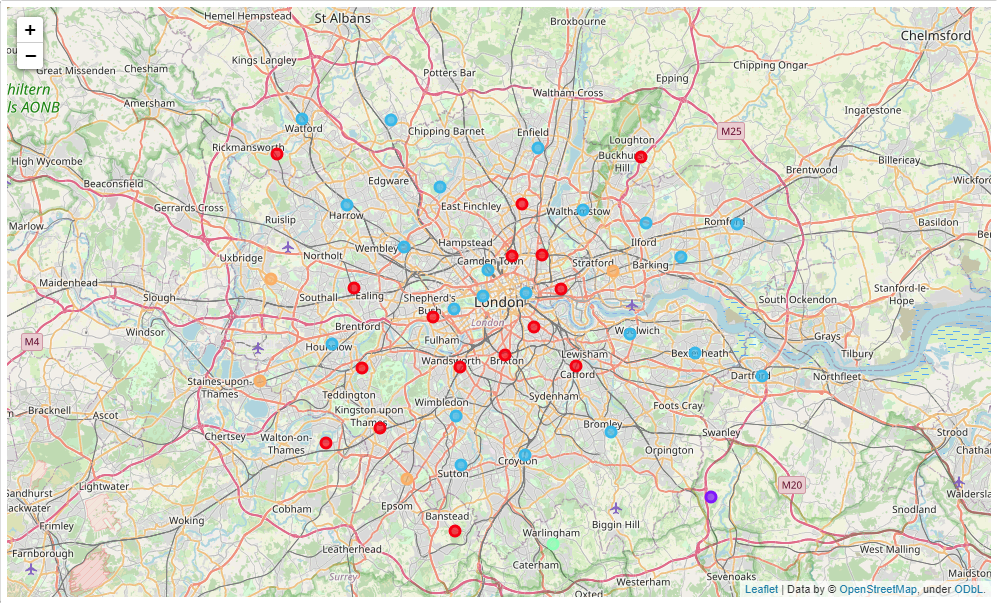

### Cluster 0 - Red

In [101]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] +[3] + list(range(4, london_merged.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue  \
9                   Ealing               0                   Pub   
10               Elmbridge               0                   Pub   
12           Epping Forest               0                  Café   
15                 Hackney               0                   Pub   
16  Hammersmith and Fulham               0                   Pub   
17                Haringey               0    Turkish Restaurant   
23               Islington               0           Coffee Shop   
25    Kingston upon Thames               0                   Pub   
26                 Lambeth               0           Coffee Shop   
27                Lewisham               0                  Park   
31    Reigate and Banstead               0                   Pub   
32    Richmond upon Thames               0                   Pub   
34               Southwark               0           Coffee Shop   
38            Three Rivers               0                   Pub   
39           Tower Hamlets               0                   Pub   
41              Wandsworth               0                   Pub   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
9                   Park           Coffee Shop                 Hotel   
10           Coffee Shop                   Bar                  Park   
12                   Pub    Italian Restaurant           Coffee Shop   
15                Bakery                  Café           Coffee Shop   
16           Coffee Shop                  Café    Italian Restaurant   
17                  Café                   Pub                  Park   
23                   Pub                  Café                  Park   
25           Coffee Shop    Italian Restaurant                  Café   
26                   Pub  Caribbean Restaurant                  Park   
27           Coffee Shop                   Pub                  Café   
31         Grocery Store           Coffee Shop    Italian Restaurant   
32                  Café                  Park    Italian Restaurant   
34               Brewery                  Park                   Pub   
38           Golf Course         Metro Station              Bus Stop   
39           Coffee Shop                  Café  Gym / Fitness Center   
41           Coffee Shop                  Café     French Restaurant   

   5th Most Common Venue  
9     Italian Restaurant  
10    Chinese Restaurant  
12         Metro Station  
15                  Park  
16    Persian Restaurant  
17           Coffee Shop  
23          Cocktail Bar  
25       Thai Restaurant  
26          Cocktail Bar  
27             Gastropub  
31                  Café  
32           Coffee Shop  
34                  Café  
38                   Gym  
39           Pizza Place  
41          Cocktail Bar

### Cluster 1 - Purple

In [102]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] +[3] + list(range(4, london_merged.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
33     Sevenoaks               1                   Pub                 Trail   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
33                 Diner          Intersection         Train Station

### Cluster 2 - Blue

In [103]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] +[3] + list(range(4, london_merged.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue  \
0     Barking and Dagenham               2                   Pub   
1                   Barnet               2                  Café   
2                   Bexley               2                   Pub   
3                    Brent               2           Coffee Shop   
4                  Bromley               2                   Pub   
5                   Camden               2           Coffee Shop   
6           City of London               2           Coffee Shop   
7                  Croydon               2                   Pub   
8                 Dartford               2                   Pub   
11                 Enfield               2           Supermarket   
14               Greenwich               2         Grocery Store   
18                  Harrow               2           Coffee Shop   
19                Havering               2           Coffee Shop   
20               Hertsmere               2                 Hotel   
22                Hounslow               2     Indian Restaurant   
24  Kensington and Chelsea               2                 Hotel   
28                  Merton               2                  Park   
30               Redbridge               2           Pizza Place   
36                  Sutton               2                   Pub   
40          Waltham Forest               2                   Pub   
42                 Watford               2           Coffee Shop   
43             Westminster               2                 Hotel   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0          Grocery Store              Bus Stop         Metro Station   
1     Turkish Restaurant         Grocery Store                  Park   
2          Grocery Store           Supermarket        Clothing Store   
3                  Hotel         Grocery Store                  Café   
4         Clothing Store           Coffee Shop           Pizza Place   
5                   Café                   Pub                  Park   
6                  Hotel        Scenic Lookout                   Pub   
7            Coffee Shop         Grocery Store        Clothing Store   
8          Grocery Store                 Hotel  Gym / Fitness Center   
11           Coffee Shop                   Pub         Train Station   
14                   Pub           Coffee Shop           Supermarket   
18     Indian Restaurant                  Park         Grocery Store   
19                   Pub           Supermarket                  Café   
20           Coffee Shop                   Pub                  Park   
22                   Pub           Coffee Shop           Supermarket   
24                Garden    Italian Restaurant                  Café   
28                   Pub           Supermarket         Grocery Store   
30     Indian Restaurant                Bakery      Department Store   
36                  Park           Coffee Shop        Clothing Store   
40           Coffee Shop         Grocery Store                  Café   
42         Grocery Store                   Pub                  Café   
43     French Restaurant             Juice Bar           Art Gallery   

     5th Most Common Venue  
0              Supermarket  
1              Supermarket  
2     Fast Food Restaurant  
3              Supermarket  
4              Supermarket  
5            Grocery Store  
6            Grocery Store  
7                     Café  
8              Pizza Place  
11      Turkish Restaurant  
14    Fast Food Restaurant  
18    Fast Food Restaurant  
19    Fast Food Restaurant  
20       Convenience Store  
22          Clothing Store  
24             Coffee Shop  
28      Italian Restaurant  
30             Coffee Shop  
36           Grocery Store  
40             Pizza Place  
42  Furniture / Home Store  
43          Clothing Store

### Cluster 3 - Green

In [104]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] +[3] + list(range(4, london_merged.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
37     Tandridge               3         Train Station                  Park   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
37              Platform           Golf Course  Fast Food Restaurant

### Cluster 4 - Orange

In [105]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] +[3] + list(range(4, london_merged.shape[1]))]]

Neighbourhood  Cluster Labels 1st Most Common Venue  \
13  Epsom and Ewell               4         Grocery Store   
21       Hillingdon               4  Fast Food Restaurant   
29           Newham               4         Grocery Store   
35       Spelthorne               4         Grocery Store   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
13                   Pub                  Café           Supermarket   
21                   Pub         Grocery Store                  Park   
29     Indian Restaurant                   Pub                  Café   
35                   Pub              Pharmacy                  Café   

   5th Most Common Venue  
13                  Park  
21             Gastropub  
29  Fast Food Restaurant  
35           Sports Club

## Results and discussion on Venue Data

It looks like there is no clear geographic link between neighbourhood location in London and the clustering of venues. Regardless we will delve deeper into the clusters (see above) to see what the venue clusters represent:

Cluster 0 (Red) - This cluster appears to represent more diverse and complex neighbourhoods given the varying locations present at each location (similar to cluster 2). But it is clear the most crime in these locations occur near pubs.

Cluster 1 (Purple) - This cluster appears to similar to cluster 3 and contains only one neighbourhood on the outskirts of London with venues near crime hotspots mainly being the pub or train station.

Cluster 2 (Blue) - This cluster appears to represent more diverse and complex neighbourhoods given the varying locations present at each location (similar to cluster 0). It appears the most common crime location for this cluster is either a pub, cafe or grocery store.

Cluster 3 (Green) - This cluster appears to be similar to cluster 1 and contains only one neighbourhood on the outskirts of London with venues near crime hotspots mainly being the train station or park.

Cluster 4 (Orange) - This cluster appears to contain mainly residential neighbourhoods without much complexity with venues near crime hotspots mainly being grocery stores and pubs which makes sense as these are areas where many people interact with each other.


## Conclusion

The purpose of this project was to segment the different neighbourhoods of London by the different types of crime which occur and the venues near crime locations. This was so that stakeholders could be aware of common crimes in a neighbourhood and any linkages to crime.

From the crime data (from the Metropolitan Police) we found that crime in London varies radially from the centre of London. With Central London being the centre of thefts and as you move outwards you will find anti-social behaviour morphing into more violent crime.

Clustering and looking at venues near the crime centroids of each neighbourhood (using the Foursquare API) there was no clear linkage between the crime location clusters and venue clusters and so it is unlikely that the clustering of venues gives rise to crime but more the opportunity at a geographic location and the people who live and work there. The venue data did however typically indicate pubs being the closest venue to the crime centroid of most neighbourhoods which makes sense as drinking does not lead to the best decisions.

Therefore, stakeholders can conclude that crime will most likely increase around locations containing pubs and in order to compensate for this local government should ensure establishments have the correct licences in place in order to compensate for potentially higher insurance costs and the need for more police presence.